
# Spotify Music Recommendation Project

## Summary
This project uses Spotify's Web API to build a personalized music recommendation system. It leverages Spotify metadata, including tracks, artists, and genres, to fetch recommendations. Additionally, it preprocesses user data and integrates pre-trained machine learning models for enhanced recommendations.

### Key Features:
- Connects to Spotify's API for track, artist, and genre information.
- Fetches recommendations based on user preferences (tracks, artists, genres).
- Handles errors and ensures robust API interactions.
- Visualizes recommendation outputs and provides fallback options in case of API failures.

---



In [1]:
!pip install spotipy boto3 pandas numpy scikit-learn torch transformers

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import numpy as np
import boto3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import time
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pathlib import Path

In [17]:
load_dotenv(dotenv_path=Path.home() / ".bash_profile")
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = CLIENT_ID = os.getenv('CLIENT_SECRET')
REDIRECT_URI = "http://localhost:8887/callback"

Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 14


In [19]:
from spotipy.oauth2 import SpotifyOAuth

auth_manager = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope="user-library-read",
    cache_path=None  # Disable caching
)
sp = spotipy.Spotify(auth_manager=auth_manager)


# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
#     client_id=CLIENT_ID,
#     client_secret=CLIENT_SECRET,
#     redirect_uri=REDIRECT_URI,
#     scope="user-library-read"
# ))


In [21]:
token_info = sp.auth_manager.get_cached_token()
print(token_info)

SpotifyOauthError: error: invalid_client, error_description: Invalid client

In [323]:
def fetch_tracks_with_metadata():
    results = sp.current_user_saved_tracks()
    tracks = []
    for item in results['items']:
        track = item['track']
        artist = sp.artist(track['artists'][0]['id'])  # Fetch artist info
        tracks.append({
            'id': track['id'],
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'popularity': track['popularity'],
            'release_date': track['album']['release_date'],
            'genres': artist['genres']  # List of genres
        })
    return tracks

In [325]:
tracks = fetch_tracks_with_metadata()
df = pd.DataFrame(tracks)
print(df.head())
print(df.tail(10))

                       id                      name           artist  \
0  1hA697u7e1jX2XM8sWA6Uy              Apna Bana Le     Sachin-Jigar   
1  0Jiaz0O4AqnJICa9PxHhaR        Mahiye Jinna Sohna    Darshan Raval   
2  32BeYxKPrig1LefHsC0Xuo  Happier Than Ever - Edit    Billie Eilish   
3  222yfkuXX3WnUYh5JKHJZH              Apna Bana Le  Aman Darya Band   
4  7cWnks0lsRtpAi87COOiXK                 O Re Piya   Salim–Sulaiman   

   popularity release_date                                             genres  
0          73   2022-12-06            [filmi, gujarati pop, modern bollywood]  
1          67   2023-08-09  [desi pop, filmi, gujarati pop, modern bollywood]  
2          68   2021-07-28                                     [art pop, pop]  
3          24   2023-04-21                                                 []  
4          69   2007-10-18             [filmi, indian folk, modern bollywood]  
                        id                name          artist  popularity  \
10  1E16f

In [329]:
def fetch_playlist_data():
    playlists = sp.current_user_playlists()
    all_tracks = []
    for playlist in playlists['items']:
        tracks = sp.playlist_tracks(playlist['id'])
        for item in tracks['items']:
            track = item['track']
            artist = sp.artist(track['artists'][0]['id'])
            all_tracks.append({
                'playlist_name': playlist['name'],
                'track_name': track['name'],
                'artist': track['artists'][0]['name'],
                'popularity': track['popularity'],
                'release_date': track['album']['release_date'],
                'genres': artist['genres']
            })
    return all_tracks

In [331]:
playlist_tracks = fetch_playlist_data()
playlist_df = pd.DataFrame(playlist_tracks)
print(playlist_df.head())

  playlist_name                          track_name        artist  popularity  \
0      Workout                              abcdefu         GAYLE          72   
1      Workout                             Broccoli          DRAM          47   
2      Workout                        Nice For What         Drake          73   
3      Workout                           Plain Jane     A$AP Ferg          68   
4      Workout   New Freezer (feat. Kendrick Lamar)  Rich The Kid          58   

  release_date                                             genres  
0   2021-08-13                    [alt z, modern alternative pop]  
1   2016-10-21  [trap, underground hip hop, viral trap, virgin...  
2   2018-06-29  [canadian hip hop, canadian pop, hip hop, pop ...  
3   2017-08-18    [hip hop, pop rap, rap, southern hip hop, trap]  
4   2018-03-30       [atl hip hop, melodic rap, plugg, rap, trap]  


In [333]:
def fetch_recommendations(seed_tracks):
    recommendations = sp.recommendations(seed_tracks=seed_tracks, limit=10)
    rec_tracks = []
    for track in recommendations['tracks']:
        rec_tracks.append({
            'id': track['id'],
            'name': track['name'],
            'artist': track['artists'][0]['name'],
            'popularity': track['popularity']
        })
    print(rec_tracks)
    return rec_tracks


In [335]:
def preprocess_data(df):
    features = ['popularity']  # Add more numeric features if needed
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])
    return df


In [337]:

normalized_df = preprocess_data(df)
print(normalized_df.head())

                       id                      name           artist  \
0  1hA697u7e1jX2XM8sWA6Uy              Apna Bana Le     Sachin-Jigar   
1  0Jiaz0O4AqnJICa9PxHhaR        Mahiye Jinna Sohna    Darshan Raval   
2  32BeYxKPrig1LefHsC0Xuo  Happier Than Ever - Edit    Billie Eilish   
3  222yfkuXX3WnUYh5JKHJZH              Apna Bana Le  Aman Darya Band   
4  7cWnks0lsRtpAi87COOiXK                 O Re Piya   Salim–Sulaiman   

   popularity release_date                                             genres  
0    0.924051   2022-12-06            [filmi, gujarati pop, modern bollywood]  
1    0.848101   2023-08-09  [desi pop, filmi, gujarati pop, modern bollywood]  
2    0.860759   2021-07-28                                     [art pop, pop]  
3    0.303797   2023-04-21                                                 []  
4    0.873418   2007-10-18             [filmi, indian folk, modern bollywood]  


In [339]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
pretrained_model = BertModel.from_pretrained("bert-base-uncased")

In [341]:
class FineTunedModel(nn.Module):
    def __init__(self, base_model, hidden_size, output_size):
        super(FineTunedModel, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.fc(pooled_output)

In [343]:
# Instantiating model
model = FineTunedModel(pretrained_model, hidden_size=768, output_size=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [345]:
text_data = normalized_df['name'] + " " + normalized_df['artist']
print(text_data)
tokens = tokenizer(list(text_data), truncation=True, padding=True, max_length=128, return_tensors="pt")
labels = torch.tensor(np.random.randint(0, 2, size=(len(text_data),)), dtype=torch.float32)

0                             Apna Bana Le Sachin-Jigar
1                      Mahiye Jinna Sohna Darshan Raval
2                Happier Than Ever - Edit Billie Eilish
3                          Apna Bana Le Aman Darya Band
4                              O Re Piya Salim–Sulaiman
5              Naatu Naatu (From "Rrr") Rahul Sipligunj
6                  Pankhida Tu Udi Jaje Kishore Manraja
7             Radha (From "Jab Harry Met Sejal") Pritam
8     Kamariya - Garba Remix By DJ Akhil Talreja (Fr...
9             Pehli Nazar Mein (From "Race") Atif Aslam
10                              Saibo - Lofi Flip VIBIE
11                                 Matilda Harry Styles
12                                     Efecto Bad Bunny
13                               La Corriente Bad Bunny
14                           Yo No Soy Celoso Bad Bunny
15                         Love Of My Life Harry Styles
16                             Daydreaming Harry Styles
17                            Little Freak Harry

In [347]:
train_size = int(0.8* len(tokens['input_ids']))
input_ids_train, input_ids_test = tokens['input_ids'][:train_size], tokens['input_ids'][train_size:]
attention_mask_train, attention_mask_test = tokens['attention_mask'][:train_size], tokens['attention_mask'][train_size:]
labels_train, labels_test = labels[:train_size], labels[train_size:]

Epoch [1/3], Loss: 0.7092
Epoch [2/3], Loss: 0.6735
Epoch [3/3], Loss: 0.9809


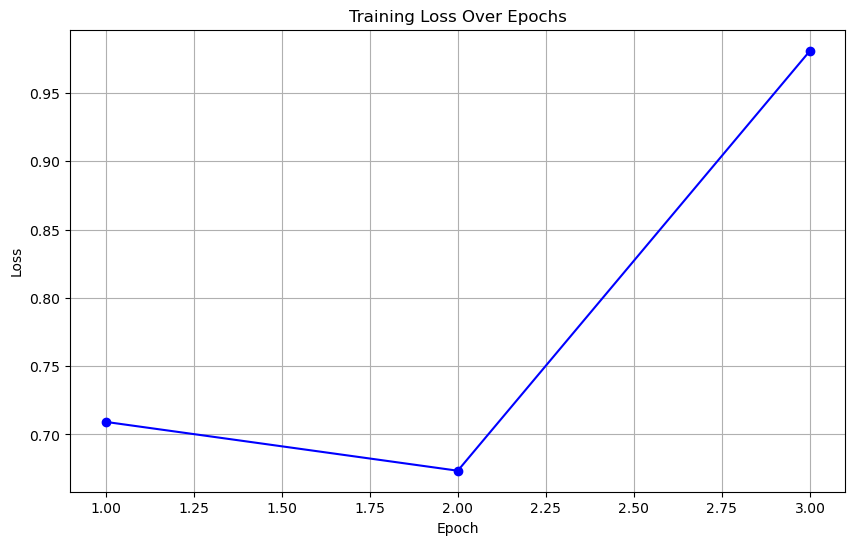

In [349]:
epochs = 3
loss_values = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids_train, attention_mask_train).squeeze()
    loss = criterion(outputs, labels_train)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item()) 
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


# Visualize the Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [351]:
def get_recommendations(seed_tracks):
    recommendations = sp.recommendations(seed_tracks=seed_tracks, limit=10)
    rec_tracks = []
    for track in recommendations['tracks']:
        rec_tracks.append({
            'id': track['id'],
            'name': track['name'],
            'artist': track['artist'],
            'popularity': track['popularity']
        })
    return rec_tracks


def fetch_recommendations_safe(seed_tracks=None, seed_artists=None, seed_genres=None):
    try:
        recommendations = sp.recommendations(seed_tracks=seed_tracks, seed_artists=seed_artists, seed_genres=seed_genres, limit=10)
        if not recommendations['tracks']:
            print("No recommendations found.")
            return []
        return recommendations['tracks']
    except spotipy.exceptions.SpotifyException as e:
        print(f"Error: {e}")
        return []


In [355]:
seed_tracks = ["4iV5W9uYEdYUVa79Axb7Rh"]  # Replace with valid track IDs
recommendations = fetch_recommendations_safe(seed_tracks)
recommendation_df = pd.DataFrame(recommendations)
print(recommendation_df.head())


HTTP Error for GET to https://api.spotify.com/v1/recommendations with Params: {'limit': 10, 'seed_tracks': '4iV5W9uYEdYUVa79Axb7Rh'} returned 404 due to None


Error: http status: 404, code:-1 - https://api.spotify.com/v1/recommendations?limit=10&seed_tracks=4iV5W9uYEdYUVa79Axb7Rh:
 None, reason: None
Empty DataFrame
Columns: []
Index: []


In [292]:
# Validate a track ID
try:
    track = sp.track("4iV5W9uYEdYUVa79Axb7Rh")
    print(f"Track Name: {track['name']}, Artist: {track['artists'][0]['name']}")
except spotipy.exceptions.SpotifyException as e:
    print(f"Error: {e}")

# Validate an artist ID
try:
    artist = sp.artist("06HL4z0CvFAxyc27GXpf02")
    print(f"Artist Name: {artist['name']}, Genres: {artist['genres']}")
except spotipy.exceptions.SpotifyException as e:
    print(f"Error: {e}")


Track Name: Prelude for Piano No. 11 in F-Sharp Minor, Artist: Eduard Abramyan
Artist Name: Taylor Swift, Genres: ['pop']
